## LR (ligand and Receptor) networks
This notebook analyzes all L-R dataframes obtained from NATMI. 
Checks edges' weight distribution, tests different thresholds for filtering and saves filtered and unfiltered LR dataframes (as a dictionary of `LRinfos` objects). It also generates and saves filtered and unfiltered networkx objects dictionaries. 
-------
Author : johaGL

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import holoviews
import pygraphviz
import networkx as nx
import pandas as pd
import matplotlib.patches as mpatches
from scipy import stats
import pickle
import igraph as ig

In [2]:
import pylab as pyl

In [3]:
class LRinfos:  
    """
    class to handle  Natmi dataframe results
    one object by result ! 
    to create object, predf is needed (the Edges opened with pandas csv)
    use 'frame' attribute to get dataframe suitable for graph conversion
    """
    def __init__(self, age, day, predf):
        self.age = age
        self.day = day
        self.predf  = predf
        self.makeunique_symbo_cellty()
        self.about = f"object age {age}, day {day}, use 'frame' attribute for more!"
        
    def makeunique_symbo_cellty(self):
        otab = self.predf
        otab['uniq_Ligand_symbol'] = otab['Ligand symbol'] + '_' + otab['Sending cluster']
        otab['uniq_Receptor_symbol'] = otab['Receptor symbol'] + '_' + otab['Target cluster']
        self.frame = otab  # this adds attribute 'frame'     
        
    def filterZero(self):  
        tmp = self.frame.loc[self.frame['Edge average expression derived specificity'] > 0]
        self.frame = tmp  # yield only non zero edges dataframe
    
    def filterOnEdgeslog10(self, cutoff):
        if min(self.frame['Edge average expression derived specificity']) < 0:
            self.filterZero()
        self.frame['log10_edge_sp'] = np.log10(np.array(self.frame['Edge average expression derived specificity']))
        tf = self.frame.loc[ self.frame['log10_edge_sp'] >= cutoff ]
        self.filtered = tf
        
           

In [4]:
ages = [ 'Young', 'Old']
days = ['D0', 'D2', 'D4', 'D7']     

<div class="alert alert-info">
  <strong>Network files : </strong>
     These tab delimited dataframe files are named identically, 
     So, what distinguishes Networks is folder location, folder location has age and day
    see variable: 
      <p style="font-family:'Lucida Console', monospace">deffilename</p>
</div> 

`deffilename`

In [13]:
"""
Network files are named identically (deffilename) , BUT : 
what distinguishes Networks is folder location, folder location has age and day !!!
"""
indatadir = "~/BulkAnalysis_plusNetwork/natmiCorrectedOut/"
print(os.getcwd())
#deffilename = 'Network_exp_0_spe_0_det_0.6_top_0_signal_lrc2p_weight_mean/'
deffilename = ""
# example opening a file: 
old_D7 = pd.read_csv(f'{indatadir}OldD7/Edges_lrc2p.csv',sep=",", header=0) 
old_D7.head(1)

/home/johanna/BulkAnalysis_plusNetwork/networks_explore


,Sending cluster,Ligand symbol,Receptor symbol,Target cluster,Ligand-expressing cells,Ligand detection rate,Ligand average expression value,Ligand total expression value,Ligand derived specificity of average expression value,Ligand derived specificity of total expression value,Receptor-expressing cells,Receptor detection rate,Receptor average expression value,Receptor total expression value,Receptor derived specificity of average expression value,Receptor derived specificity of total expression value,Edge average expression weight,Edge average expression derived specificity,Edge total expression weight,Edge total expression derived specificity
0,ECs,Agt,Mas1,ECs,1,0.333333,0.058046,0.174139,0.027605,0.027605,3,1.0,1.038072,3.114217,0.212692,0.212692,0.060256,0.005871,0.542307,0.005871


In [16]:
"""
all LRinfos objects are stocked in dictionary
"""
lr = {}      
for i in ages:
    lr[i] = {}
    for j in days:   
        predf = pd.read_csv(f'{indatadir}{i}{j}/Edges_lrc2p.csv',sep=",", header=0)  
        myob = LRinfos(i, j, predf)
        lr[i][j] = myob      

In [17]:
print(lr['Young']['D2'].about)

object age Young, day D2, use 'frame' attribute for more!


In [18]:
lr['Young']['D2'].frame.head(1)

,Sending cluster,Ligand symbol,Receptor symbol,Target cluster,Ligand-expressing cells,Ligand detection rate,Ligand average expression value,Ligand total expression value,Ligand derived specificity of average expression value,Ligand derived specificity of total expression value,...,Receptor average expression value,Receptor total expression value,Receptor derived specificity of average expression value,Receptor derived specificity of total expression value,Edge average expression weight,Edge average expression derived specificity,Edge total expression weight,Edge total expression derived specificity,uniq_Ligand_symbol,uniq_Receptor_symbol
0,ECs,Agt,Mas1,ECs,2,0.666667,0.121402,0.364207,0.285618,0.285618,...,0.388631,1.165893,0.39784,0.39784,0.047181,0.11363,0.424626,0.11363,Agt_ECs,Mas1_ECs


In [19]:
max(lr['Old']['D0'].frame['Edge average expression derived specificity'])

1.0

In [20]:
# by default , Natmi yields edges exhibiting specificities > 0
# verify : 
for age in ages:
    for day in days:
        if (min(lr[age][day].frame['Edge average expression derived specificity']) > 0):
            print(f'{age}+{day} specificities edges are all over zero')
        else : 
            print(f'{age}+{day} HAS A MIN VALUE EQUAL TO ZERO, FILTER OUT using obj.filterZero()')        

Young+D0 specificities edges are all over zero
Young+D2 specificities edges are all over zero
Young+D4 specificities edges are all over zero
Young+D7 specificities edges are all over zero
Old+D0 specificities edges are all over zero
Old+D2 specificities edges are all over zero
Old+D4 specificities edges are all over zero
Old+D7 specificities edges are all over zero


Text(0.5, 0.98, 'Edge specificities, given values')

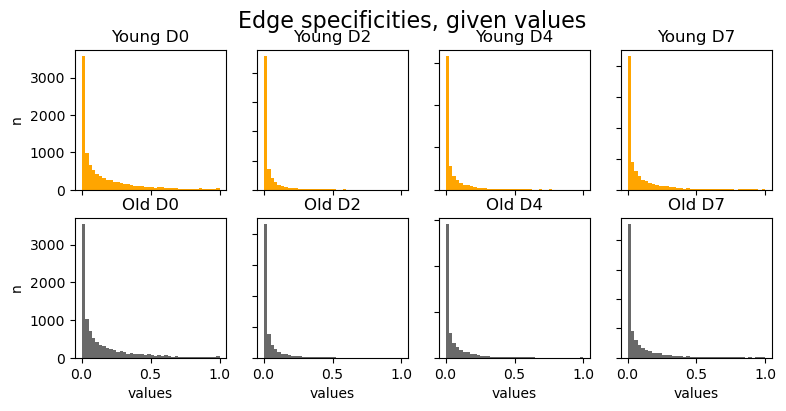

In [21]:
""" plotting edge specificities """
histocols = ['orange', 'dimgray']
fig, axs = plt.subplots(2, 4, figsize=(9,4))
for rawi in range(2):
    AGE = ages[rawi]
    for coli in range(4):
        DAY = days[coli]
        tmpvec = lr[AGE][DAY].frame['Edge average expression derived specificity']        
        axs[rawi, coli].hist(tmpvec,
                            color=histocols[rawi], bins=40)
        axs[rawi, coli].set_title(f'{ages[rawi]} {days[coli]}')
        

for ax in axs.flat:
    ax.set(xlabel='values', ylabel='n')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(f'Edge specificities, given values', fontsize=16)

**This is very similar to TAu indexes, being 1 most specific, and 0 housekeeping !**  . Most have weak specificities, do preservative approach, by using log10 to filter. First we must explore log transformed values

Text(0.5, 0.98, 'Edge specificities, log10 (x)')

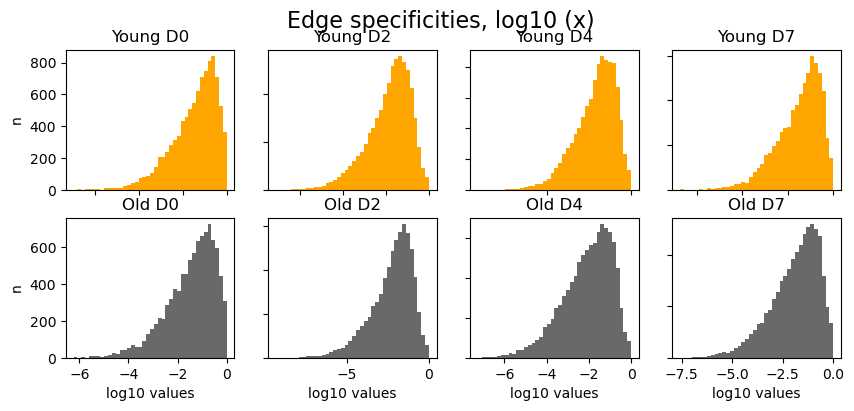

In [22]:
""" plotting edge specificities, log """

histocols = ['orange', 'dimgray']
fig, axs = plt.subplots(2, 4, figsize=(10,4))
for rawi in range(2):
    AGE = ages[rawi]
    for coli in range(4):
        DAY = days[coli]
        tmpvec = lr[AGE][DAY].frame['Edge average expression derived specificity']        
        axs[rawi, coli].hist(np.log10(np.array(tmpvec)),
                            color=histocols[rawi], bins=40)
        axs[rawi, coli].set_title(f'{ages[rawi]} {days[coli]}')        

for ax in axs.flat:
    ax.set(xlabel='log10 values', ylabel='n')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(f'Edge specificities, log10 (x)', fontsize=16)

The closer to 1 (0 in log10 value) the more the edge is predicted to be 'specific'
We see that most of edges specificities are concentrated between 0.1 and 0.001 (-1 and -3 in log10 value). 
These plots allowed us to know about data distribution, but we need
to scale them to  values suitable for making graph style visualizations.

### filter , using function from my 'LRinfos' class : 

The function 'filterOnEdgeslog10' is defined inside the class (above), cutoff is customizable

In [23]:
## filter and check edges
for age in ages:
    for day in days:
        lr[age][day].filterOnEdgeslog10(-0.5)   # using -0.5 as log10 cutoff

In [24]:
lr['Young']['D4'].filtered['log10_edge_sp']

6       -0.251691
19      -0.136827
26      -0.163615
31      -0.017328
35      -0.040090
           ...   
25492   -0.222967
25502   -0.220699
25527   -0.325724
25602   -0.375000
25606   -0.429450
Name: log10_edge_sp, Length: 1053, dtype: float64

Text(0.5, 0.98, 'Edge specificities, POST filter ')

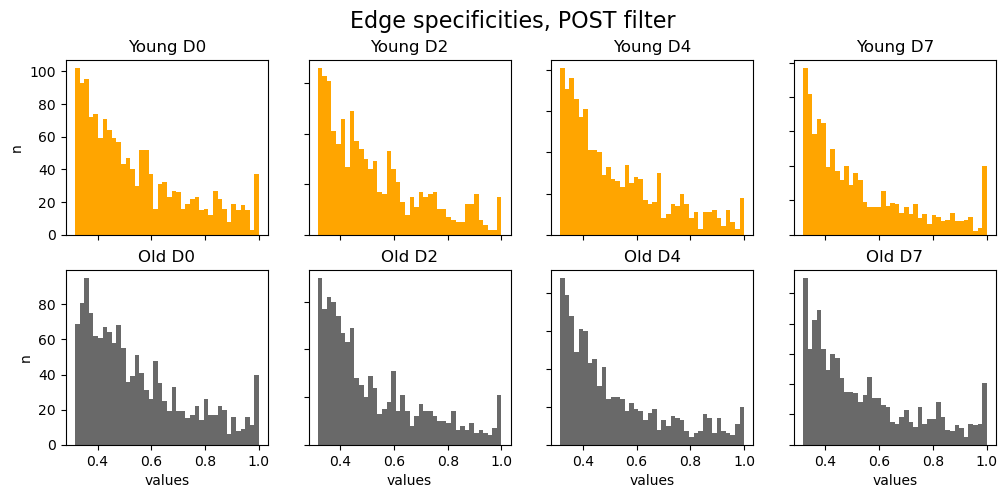

In [25]:
## plotting POST filter
""" plotting POST filter edge specificities """
histocols = ['orange', 'dimgray']
fig, axs = plt.subplots(2, 4, figsize=(12,5))
for rawi in range(2):
    AGE = ages[rawi]
    for coli in range(4):
        DAY = days[coli]
        tmpvec = lr[AGE][DAY].filtered['Edge average expression derived specificity']     
        #tmpvec = lr[AGE][DAY].filtered['log10_edge_sp']
        axs[rawi, coli].hist(np.array(tmpvec),
                            color=histocols[rawi], bins=40)
        axs[rawi, coli].set_title(f'{ages[rawi]} {days[coli]}')
        

for ax in axs.flat:
    ax.set(xlabel='values', ylabel='n')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(f'Edge specificities, POST filter ', fontsize=16)

In [26]:
for age in ages:
    for day in days:
        print((age,day))
        print(lr[age][day].filtered.shape)

('Young', 'D0')
(1505, 23)
('Young', 'D2')
(882, 23)
('Young', 'D4')
(1053, 23)
('Young', 'D7')
(1285, 23)
('Old', 'D0')
(1453, 23)
('Old', 'D2')
(891, 23)
('Old', 'D4')
(985, 23)
('Old', 'D7')
(1286, 23)


That was very stringent (-0.5), let's set another cutoff

In [27]:
for age in ages:
    for day in days:
        lr[age][day].filterOnEdgeslog10(-1) 

### Compare filtered and unfiltered number of edges:
Making a simple table

In [28]:
tabularmanual = {'notfiltered' : [], 'filtered' : []}
manualindexes = []
for i in ages:
    for j in days:
        tabularmanual['notfiltered'].append(lr[i][j].frame.shape[0])
        tabularmanual['filtered'].append(lr[i][j].filtered.shape[0])
        manualindexes.append(f'{i}_{j}')
#    = {'notfiltered' : [1,2,3], 'filtered' : [4,5,6]}

In [29]:
lr['Old']['D0'].filtered.shape[0]

3682

In [30]:
print("compare unfiltered vs filtered NUMBER OF EDGES, as filter done on edges specs")
pd.DataFrame(tabularmanual, index = manualindexes)

compare unfiltered vs filtered NUMBER OF EDGES, as filter done on edges specs


,notfiltered,filtered
Young_D0,9547,3827
Young_D2,33746,4100
Young_D4,25758,4437
Young_D7,16876,4405
Old_D0,9467,3682
Old_D2,33051,4245
Old_D4,24504,4531
Old_D7,17390,4406


Text(0.5, 0.98, 'Edge specificities, POST filter ')

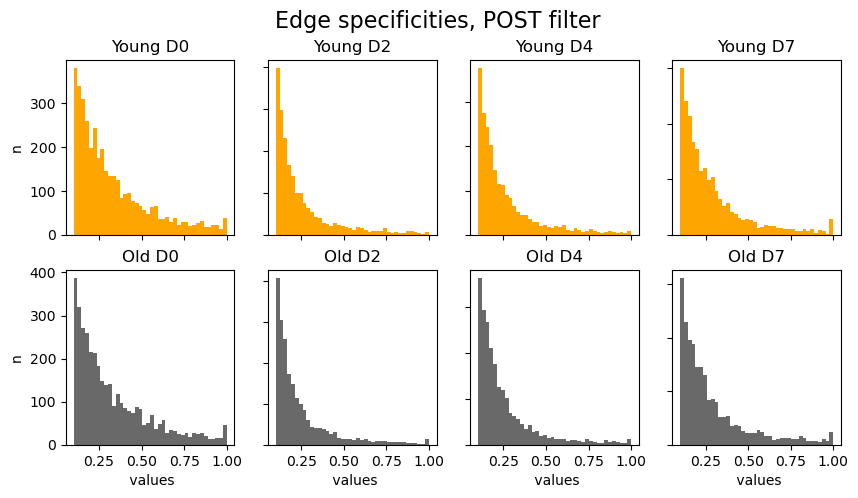

In [31]:
""" plotting POST filter edge specificities """
histocols = ['orange', 'dimgray']
fig, axs = plt.subplots(2, 4, figsize=(10,5))
for rawi in range(2):
    AGE = ages[rawi]
    for coli in range(4):
        DAY = days[coli]
        tmpvec = lr[AGE][DAY].filtered['Edge average expression derived specificity']     
        #tmpvec = lr[AGE][DAY].filtered['log10_edge_sp']
        axs[rawi, coli].hist(np.array(tmpvec),
                            color=histocols[rawi], bins=40)
        axs[rawi, coli].set_title(f'{ages[rawi]} {days[coli]}')
        

for ax in axs.flat:
    ax.set(xlabel=' values', ylabel='n')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(f'Edge specificities, POST filter ', fontsize=16)

## New function to get Networkx object from dataframe
#### and give it colors as universally defined, from specialized color-blindness friendly palette (defined from R scripts)

In [32]:
def getCustomGraph(adf, celltycolors):
    """Inputs :  adf (a dataframe) , and
                 colors in the form of a dictionary.
    Output:  Networkx object"""
    G = nx.DiGraph()
    for index,row in adf.iterrows():
        nodefrom = row['uniq_Ligand_symbol']
        nodeto = row['uniq_Receptor_symbol']
        celltypefrom = row['Sending cluster']
        celltypeto = row['Target cluster']
        G.add_node(nodefrom,
                    nodetype = 'sender',
                    celltype = celltypefrom,
                    genesym = row['Ligand symbol'],
                    color = celltycolors[celltypefrom],
                    specificity = row['Ligand derived specificity of average expression value'])
        G.add_node(nodeto,
                    nodetype = 'receiver',
                    celltype = celltypeto, 
                    genesym = row['Receptor symbol'],
                    color = celltycolors[celltypeto],
                    specificity = row['Receptor derived specificity of average expression value'])
        G.add_edge(nodefrom,nodeto, origtype = nodefrom,
                    ecolor = celltycolors[celltypefrom],
                    weight = row['Edge average expression derived specificity']) 
    return G

In [37]:
celltycolors = {
  "ECs" : "#0072B2",
  "FAPs" : "#F0E442",
  "Inflammatory-Mac" : "#D55E00",
  "Resolving-Mac" :  "#CC79A7",
  "Neutrophils" : "#009E73",
  "MuSCs" : "#56B4E9"
}

In [38]:
## creating new dictionary to stock Networkx objects
dxfiltered = {}
dxunfiltered = {}

In [39]:
## calling function iteratively while populating dictionary
for age in ages:
    dxfiltered[age] = {}
    dxunfiltered[age] = {}
    for day in days:
        tmpGfi = getCustomGraph(lr[age][day].filtered, celltycolors)
        tmpGuf = getCustomGraph(lr[age][day].frame, celltycolors)
        dxfiltered[age][day] = tmpGfi
        dxunfiltered[age][day] = tmpGuf
        

In [40]:
len(dxfiltered['Old']['D4'].nodes())

2004

In [43]:
len(dxunfiltered['Old']['D4'].nodes())

3831

##  Saving files
    - lr : contains objects of the class 'LRinfos' which I created to stock dataframes
            - `.frame` attribute contains unfiltered dataframe
            - `.filtered` attribute contains filtered dataframe
    - dxfiltered and dxunfiltered : contain networkx objects

    saving  dictionaries (lr  and filtered and unfiltered graphs dictionaries) into different files

In [45]:
pickle.dump(lr, open( "graphobjs/dictio_lr.p", "wb" ))

In [46]:
pickle.dump(dxfiltered, open( "graphobjs/dictio_dx_filtered.p", "wb" ))

In [47]:
pickle.dump(dxunfiltered, open( "graphobjs/dictio_dx_unfi.p", "wb" ))

In [48]:
# to open just: lr = pickle.load( open( "graphobjs/dictio_lr.p", "rb" ) )

In [49]:
plt.close('all')

## Save interoperable igraph objects

For some operations, networkx is more robust than igraph (for example, for transformating into undirected graph, or checking number of connected components for directed graph). However, as we are going to use output to import in a Shiny application, I have decided to use igraph objects for interoperability purposes.

In [50]:
dxfiltered = pickle.load( open('graphobjs/dictio_dx_filtered.p', 'rb') )
dxunfiltered = pickle.load( open('graphobjs/dictio_dx_unfi.p', 'rb') )

In [51]:
ages = ["Young", "Old"]
days = ["D0", "D2", "D4", "D7"]
for age in ages:
    print(age)
    for day in days:
        tmp_igraph_filt = ig.Graph.from_networkx(dxfiltered[age][day])
        tmp_igraph_unfi = ig.Graph.from_networkx(dxunfiltered[age][day])
        tmp_igraph_filt.write_graphml(f'graphobjs/{age}_{day}_igraph_filt.ml')
        tmp_igraph_unfi.write_graphml(f'graphobjs/{age}_{day}_igraph_unfi.ml')

Young
Old


##### Saving pdf figures and  dictionaries (lr, dxfiltered and dxunfiltered):

 * No longer Saving pdf figures whole networks. Just go directly to 

* obtaining huge size legend for graphical editing purposes

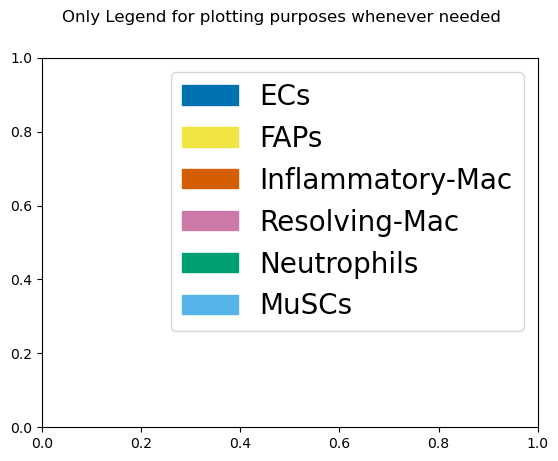

In [44]:
color_patches = []
for key, value in celltycolors.items():
    tmppatch = mpatches.Patch(color=value, label=key)
    color_patches.append(tmppatch)
    
onlylegend = plt.figure()
plt.legend(handles=color_patches, prop={'size': 20})
onlylegend.suptitle('Only Legend for plotting purposes whenever needed')
onlylegend.savefig('onlyLegend.pdf')